In [1]:
import numpy as np
import matplotlib as m
import matplotlib.pyplot as plt
import copy as c
import pyemma 
from tqdm import tqdm 
import gromacs as gmx
import scipy.stats as sct
import scipy.optimize as sco
import sklearn as skl
from sklearn.model_selection import train_test_split as splt
import sklearn.metrics as mtr
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as cfm
from sklearn.ensemble import RandomForestClassifier as rfc
import pickle as pkl

/home/jayakrishnak/softwares/anaconda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


NOTE: Some configuration directories are not set up yet: 
	/home/jayakrishnak/.gromacswrapper
	/home/jayakrishnak/.gromacswrapper/qscripts
	/home/jayakrishnak/.gromacswrapper/templates
NOTE: You can create the configuration file and directories with:
	>>> import gromacs
	>>> gromacs.config.setup()


# Datas

In [2]:
cpairs = np.loadtxt('../contact_pairs.txt',dtype='str')

In [44]:
afeatures = []
#
path = '../../8_protein_conformations_and_apo_states/2_mindist_files/numpy_converted_files/'

for t in tqdm([1,2,3]):
    for s in ['closed','open']:
        pfeatures = []
        for cp in cpairs:
            dd = np.load(path+'mindist_r'+cp[0]+'_r'+cp[1]+'_apo_'+s+'_'+str(t)+'.npy')
            if len(pfeatures) == 0:
                pfeatures = c.deepcopy(dd)
            else:
                pfeatures = np.column_stack((pfeatures,dd))
                #
        if len(afeatures) == 0:
            afeatures = c.deepcopy(pfeatures)
        else:
            afeatures = np.concatenate((afeatures,pfeatures))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [2:51:06<00:00, 3422.03s/it]


In [45]:
bfeatures = []
#
path='../1_bound_data/numpy_converted_files/'
for t in tqdm([1,2,3,4]):
    pfeatures = []
    for cp in cpairs:
        dd = np.load(path+'mindist_r'+cp[0]+'_r'+cp[1]+'_bound_'+str(t)+'.npy')
        if len(pfeatures) == 0:
            pfeatures = c.deepcopy(dd)
        else:
            pfeatures = np.column_stack((pfeatures,dd))
            #
    if len(bfeatures) == 0:
        bfeatures = c.deepcopy(pfeatures)
    else:
        bfeatures = np.concatenate((bfeatures,pfeatures))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [1:31:17<00:00, 1369.45s/it]


In [48]:
labels = np.asarray([0 for i in range(len(afeatures))] + [1 for i in range(len(bfeatures))])

In [50]:
features = np.concatenate((afeatures,bfeatures))

In [55]:
# freeing memory
#
afeatures = None
bfeatures = None

In [56]:
np.save('features.npy',features)
np.save('labels.npy',labels)

In [11]:
features = np.load('features.npy')
labels = np.load('labels.npy')

# random forest classifier

In [5]:
ftrain, ftest, ltrain, ltest  = splt(features,labels, test_size=0.3, random_state=0)

In [7]:
clf0 = rfc(n_estimators=1000, n_jobs=16, random_state=0)

In [8]:
clf0.fit(ftrain,ltrain)

RandomForestClassifier(n_estimators=1000, n_jobs=16, random_state=0)

In [38]:
pkl.dump(clf0,open('model0.pkl','wb'))

In [9]:
predicted0_train = clf0.predict(ftrain)
predicted0_test = clf0.predict(ftest)

In [11]:
acc(ltrain,predicted0_train)

1.0

In [12]:
acc(ltest,predicted0_test)

1.0

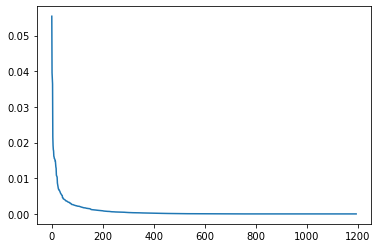

In [17]:
plt.plot(clf0.feature_importances_[clf0.feature_importances_.argsort()][::-1])

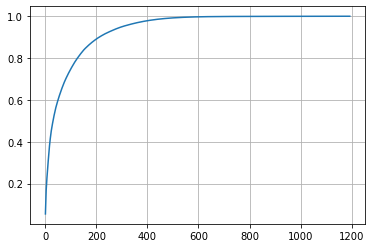

In [19]:
plt.plot(np.cumsum(clf0.feature_importances_[clf0.feature_importances_.argsort()][::-1]))
plt.grid()

In [25]:
cmatrix0 = cfm(predicted0_test,ltest)
cmatrix0 = cmatrix0/cmatrix0.sum()
cmatrix0

array([[0.59219209, 0.        ],
       [0.        , 0.40780791]])

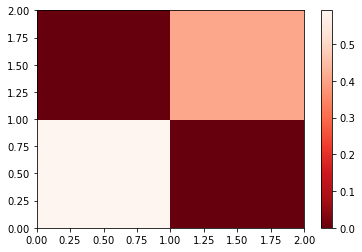

In [35]:
px = plt.pcolor(cmatrix0,cmap='Reds_r')
plt.colorbar(px)

# for cross_validation

n=49
randoms = np.zeros((n))
for i in range(n):
    randoms[i] = np.random.randint(0,1000)

In [42]:
randoms

array([383.,  52., 339.,   4., 415., 273., 755., 269., 397., 975., 864.,
       220., 184., 497., 916., 647., 238., 878.,  67.,   7., 603., 669.,
       628.,  35., 510., 406., 970., 962., 881., 646., 465., 537., 617.,
        72., 412.,  80., 293., 851., 877., 945.,   7., 547., 737., 169.,
       767., 624., 713., 145., 879.])

In [43]:
np.save('randoms.npy',randoms)

# analysis

<font size=6>
    <br>
    <center>
        Analysis protocol <br><br>
    </center>
</font>

<font size=4>
    detecting conformational changes in entire protein (by RF approach) <br><br>
    i.  close > open (allosteric changes occuring in close > open transition) <br><br>
    ii. apo > bound <br><br>
    are conformational changes in apo > bound are same (similarity index) as close > open (both proximal and distal(allosteric)) <br>
    i.e., ligand binding process is crediting for conformation changes <br>
    in this case, allosteric changes can turned out to be important <br>
    also adding bp volume in this <br><br>
    are the changes induced / conformational selection --- (PRS) conf sel model <br><br> <br><br>
</font>


<font size=6>
    <center>
        $   SI = \frac  { \Sigma_i ( f1_i + f2_i) } { \Sigma (f1 + f2)}    $ <br>
    </center>
</font>
<font size=4>
    SI - similarity index <br>
    $f1_i$ - weight (probability of occuring in cross validated model) of feature i in state 1 <br>
</font>



<font size=6>
    <br><br><br>
    RF approach <br><br>
</font>

<font size=4>
    defining contact matrix time profile as features <br><br>
    labelling based on apo/bound or MSM derived open/close/intermediate states<br><br>
    RF classification on 70% training data - checking accuracy on test data - if learning greater than 0.95, <br><br>
    replicating the procedure for 49 other cross validated samples <br><br>
    measuring hold-out accuracy as mean+-std on total 50 cross validated samples <br><br>
    taking top features for each RF model, checking that not very much different (error analysis) <br><br>
    taking features appearing in more than 50% (adjustable) of models <br><br>
    studying the behaviour of above features <br><br>
    <br>
</font>

In [3]:
cpairs = np.loadtxt('../contact_pairs.txt', dtype=str)

In [7]:
top95_features = []
cutoff = 0.95

for m in tqdm(range(50)):
    
    if m==0: clf = pkl.load(open('model0.pkl','rb'))
    else: clf = pkl.load(open(f'1_cross_validation/model_{m}.pkl', 'rb'))
        
    fimportances = clf.feature_importances_
    findexes = fimportances.argsort()[::-1]
    fimportances = fimportances[findexes]
    lindex = np.where( np.cumsum(fimportances) >= cutoff )[0][0]
    fimportances = np.column_stack(( findexes[:lindex], fimportances[:lindex] ))
    top95_features.append(fimportances)
    
top95_features = np.array(top95_features)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:53<00:00,  2.26s/it]
/tmp/ipykernel_7826/3329571488.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top95_features = np.array(top95_features)


In [8]:
nreplicas = 50

common_top95_features = []
dd = np.concatenate((top95_features))[:,0].astype(int)
for i in np.unique(dd):
    if len(np.where(dd == i)[0]) == nreplicas:
        common_top95_features.append(i)

nfeatures_top95 = []
diff_importances_top95 = []
for i in range(nreplicas):
    nfeatures_top95.append( top95_features[i].shape[0] )
    
    ss = 0
    for j in top95_features[i]:
        if j[0] not in common_top95_features:
            ss += j[1]
    diff_importances_top95.append(ss/0.95)
    
nfeatures_top95 = [ np.mean(nfeatures_top95), np.std(nfeatures_top95) ]
diff_importances_top95 = [ np.mean(diff_importances_top95), np.std(diff_importances_top95) ]

In [9]:
nfeatures_top95

[304.46, 2.523568901377571]

In [10]:
diff_importances_top95

[0.046215151485903175, 0.002067985254796445]

In [11]:
all_top95_features = {}
for i in range(nreplicas):
    for j in top95_features[i]:
        if int(j[0]) not in all_top95_features.keys():
            all_top95_features[int(j[0])] = []
        all_top95_features[int(j[0])].append(j[1])

major_top95_features = {}
for key in all_top95_features:
    if len(all_top95_features[key]) > 45:
        major_top95_features[key] = [ np.mean(all_top95_features[key]), np.std(all_top95_features[key]) ]

In [16]:
np.save('saved_files/major_top95_features.npy', 
        np.column_stack(( list(major_top95_features.keys()), list(major_top95_features.values()) )) 
       )

In [4]:
major_top95_features = {i[0]:i[1:] for i in np.load('saved_files/major_top95_features.npy')}

In [5]:
len(major_top95_features)

256

In [15]:
means_apo = np.zeros((len(major_top95_features.keys())))
means_bound = np.zeros((len(major_top95_features.keys())))

afeatures = features[ np.where(labels == 0) ]
bfeatures = features[ np.where(labels == 1) ]

keys=list(major_top95_features.keys())
for i in range(len(keys)):
    means_apo[i] = np.mean(afeatures[:,int(keys[i])])
    means_bound[i] = np.mean(bfeatures[:,int(keys[i])])

afeatures, bfeatures, features, labels = 0, 0, 0, 0

In [18]:
np.save('saved_files/means_apo.npy', means_apo)
np.save('saved_files/means_bound.npy', means_bound)

In [19]:
means_apo = np.load('saved_files/means_apo.npy')
means_bound = np.load('saved_files/means_bound.npy')

(0.0, 257.0)

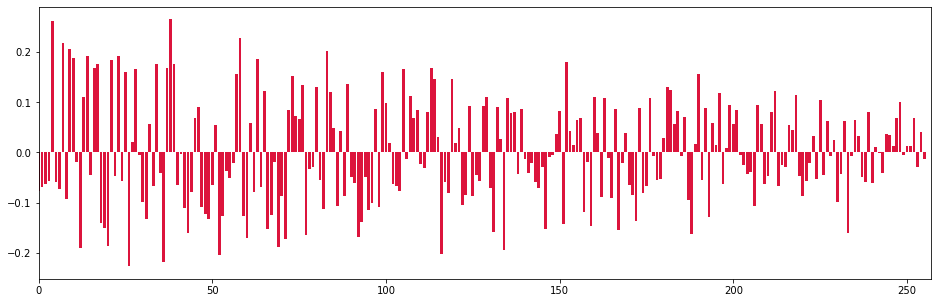

In [20]:
fig, ax = plt.subplots(1, figsize=(16,5))
ax.bar(range(len(means_apo)), means_apo - means_bound, color='crimson')
ax.set_xlim(0,257)

# comparison with closed > open conformation

In [21]:
open_closed_major_top95_features = { i[0]:i[1:] for i in np.load('../../8_protein_conformations_and_apo_states/4_rf/major_top95_features.npy') }

In [36]:
keys_open_closed = np.array(list(open_closed_major_top95_features.keys())).astype(int)
keys_apo_bound = np.array(list(major_top95_features.keys())).astype(int)

In [131]:
common_pairs = np.intersect1d(keys_open_closed, keys_apo_bound)

means_open = np.load('../../8_protein_conformations_and_apo_states/4_rf/saved_files/means_open.npy')
means_closed = np.load('../../8_protein_conformations_and_apo_states/4_rf/saved_files/means_closed.npy')

means_pr = means_open - means_closed
means_binding = means_bound - means_apo

means_common = np.zeros((len(common_pairs), 2))
for i in range(len(common_pairs)):
    indp = np.where(keys_open_closed == common_pairs[i])[0][0]
    indb = np.where(keys_apo_bound == common_pairs[i])[0][0]
    means_common[i] = [means_pr[indp], means_binding[indb]]

width=0.4
fig,ax=plt.subplots(1,figsize=(16,4))
ax.bar( np.arange(len(means_common))-width/2, means_common[:,0], width=width, color='crimson' )
ax.bar( np.arange(len(means_common))+width/2, means_common[:,1], width=width, color='dodgerblue' )
ax.set_xlim(-1,123)

def check_vals(vals, both=0.1,):
    if np.min(np.abs(vals)) <= both:
        return False
    else:
        if (np.min(vals) > 0) or (np.max(vals) < 0):
            return False
        else:
            return True

ncommons = []
for i in range(len(common_pairs)):
    if check_vals(means_common[i]):
        ncommons.append(i)

common_pairs = np.delete(common_pairs, ncommons)

<font size=4>
    DIRECTIONALITY    Not considered

In [132]:
p1, e1 = 0, 0
p2, e2 = 0, 0
for i in common_pairs:
    p1 += major_top95_features[i][0]
    e1 += major_top95_features[i][1]
    p2 += open_closed_major_top95_features[i][0]
    e2 += open_closed_major_top95_features[i][1]
    
total_apo_bound = np.sum(np.array(list(major_top95_features.values()))[:,0])
total_open_closed = np.sum(np.array(list(open_closed_major_top95_features.values()))[:,0])
p1 = p1/total_apo_bound
p2 = p2/total_open_closed
print(f'{p1} +- {e1}')
print(f'{p2} +- {e2}')

0.4604603213969065 +- 0.05533828954537165
0.7809121113319357 +- 0.1010291224465675


In [133]:
total_apo_bound

0.924358468374499

In [134]:
total_open_closed

0.9255097984560371

## plotting

In [146]:
radius_max = 0.4
radius_min = 0.1

### apo > bound

In [147]:
values_apo_bound = np.array(list(major_top95_features.values()))[:,0]
keys_apo_bound = np.array(list(major_top95_features.keys()))

In [148]:
max_apo_bound = values_apo_bound.max()
min_apo_bound = values_apo_bound.min()
print(max_apo_bound, min_apo_bound)

0.0530397396141639 0.0004505266610467952


In [149]:
values_apo_bound = (values_apo_bound - min_apo_bound) / max_apo_bound
values_apo_bound = values_apo_bound * (radius_max - radius_min) + radius_min

In [150]:
dd = {keys_apo_bound[i]:values_apo_bound[i] for i in range(len(values_apo_bound))}
specific_apo_bound = []
common_apo_bound = []
for i in dd.keys():
    if i in common_pairs:
        common_apo_bound.append( list(cpairs[int(i)]) + [dd[i]] )
    else:
        specific_apo_bound.append( list(cpairs[int(i)]) + [dd[i]] )

In [151]:
np.savetxt('plotting_files/common_apo_bound.txt', common_apo_bound, fmt='%s')
np.savetxt('plotting_files/specific_apo_bound.txt', specific_apo_bound, fmt='%s')

### closed > open

In [152]:
values_open_closed = np.array(list(open_closed_major_top95_features.values()))[:,0]
keys_open_closed = np.array(list(open_closed_major_top95_features.keys()))

In [153]:
max_open_closed = values_open_closed.max()
min_open_closed = values_open_closed.min()
print(max_open_closed, min_open_closed)

0.0441063758428277 0.0006376537281532213


In [154]:
values_open_closed = (values_open_closed - min_open_closed) / max_open_closed
values_open_closed = values_open_closed * (radius_max - radius_min) + radius_min

In [155]:
dd = {keys_open_closed[i]:values_open_closed[i] for i in range(len(values_open_closed))}
specific_open_closed = []
common_open_closed = []
for i in dd.keys():
    if i in common_pairs:
        common_open_closed.append( list(cpairs[int(i)]) + [dd[i]] )
    else:
        specific_open_closed.append( list(cpairs[int(i)]) + [dd[i]] )

In [156]:
np.savetxt('plotting_files/common_open_closed.txt', common_open_closed, fmt='%s')
np.savetxt('plotting_files/specific_open_closed.txt', specific_open_closed, fmt='%s')

### residues

<font size=4>
    <br>
    the value of each residue dictates that the particular residue is involved in that much feature importance (aggregated).
    <br><br>
    the residues are divided into three categories :: <br>
    1: involved in specifics only <br>
    2: involved in common only<br>
    3: involved in both <br>
    <br>
</font>

In [157]:
residues_all_apo_bound = {}
for i in major_top95_features.keys():
    for j in cpairs[int(i)]:
        if j not in residues_all_apo_bound.keys():
            residues_all_apo_bound[j] = [0,0]
        residues_all_apo_bound[j] = [ major_top95_features[i][0] + residues_all_apo_bound[j][0],
                                    major_top95_features[i][1] + residues_all_apo_bound[j][1]]

In [158]:
residues_all_open_closed = {}
for i in open_closed_major_top95_features.keys():
    for j in cpairs[int(i)]:
        if j not in residues_all_open_closed.keys():
            residues_all_open_closed[j] = [0,0]
        residues_all_open_closed[j] = [ open_closed_major_top95_features[i][0] + residues_all_open_closed[j][0],
                                    open_closed_major_top95_features[i][1] + residues_all_open_closed[j][1]]

In [159]:
len(residues_all_apo_bound)

128

In [160]:
len(residues_all_open_closed)

95

In [260]:
k1 = np.array(list(residues_all_apo_bound.keys()))
k2 = np.array(list(residues_all_open_closed.keys()))
v1 = np.array(list(residues_all_apo_bound.values()))[:,0]
v2 = np.array(list(residues_all_open_closed.values()))[:,0]

In [261]:
p1, p2, e1, e2 = 0, 0, 0, 0
for i in np.intersect1d(k1, k2):
    p1 += residues_all_apo_bound[i][0]
    e1 += residues_all_apo_bound[i][1]
    p2 += residues_all_open_closed[i][0]
    e2 += residues_all_open_closed[i][1]
print(f'{p1/np.sum(v1)} +- {e1}')
print(f'{p2/np.sum(v2)} +- {e2}')

0.7781711685680718 +- 0.18147324849711602
0.9898957986507213 +- 0.26759505279828516


In [203]:
def sort_dict(dic, otype='descending'):
    keys = list(dic.keys())
    vals = list(dic.values())
    inds = np.argsort( np.array(vals)[:,0] )
    if otype == 'descending':
        inds = inds[::-1]
    return {keys[i]:vals[i] for i in inds}

def sort_dict2(dic, otype='descending'):
    keys = list(dic.keys())
    vals = list(dic.values())
    inds = np.argsort( np.array(vals) )
    if otype == 'descending':
        inds = inds[::-1]
    return {keys[i]:vals[i] for i in inds}

In [204]:
residues_common_apo_bound = {}
residues_specific_apo_bound = {}
residues_both_apo_bound = {}
residues_both_diff_apo_bound = {}   # comparative difference (if more in apo bound)

for res in residues_all_apo_bound.keys():
    
    if res in np.array(common_apo_bound) and res in np.array(specific_apo_bound):
        residues_both_apo_bound[res] = residues_all_apo_bound[res]
        residues_both_diff_apo_bound[res] = residues_all_apo_bound[res][0] - residues_all_open_closed[res][0]
        
    elif res in np.array(common_apo_bound):
        residues_common_apo_bound[res] = residues_all_apo_bound[res]
        
    elif res in np.array(specific_apo_bound):
        residues_specific_apo_bound[res] = residues_all_apo_bound[res]
        
residues_common_apo_bound = sort_dict(residues_common_apo_bound)
residues_specific_apo_bound = sort_dict(residues_specific_apo_bound)
residues_both_apo_bound = sort_dict(residues_both_apo_bound)
residues_both_diff_apo_bound = sort_dict2(residues_both_diff_apo_bound)

In [206]:
np.save('saved_files/residues_common_apo_bound.npy',
       np.column_stack((list(residues_common_apo_bound.keys()), list(residues_common_apo_bound.values()))))
np.save('saved_files/residues_specific_apo_bound.npy',
       np.column_stack((list(residues_specific_apo_bound.keys()), list(residues_specific_apo_bound.values()))))
np.save('saved_files/residues_both_apo_bound.npy',
       np.column_stack((list(residues_both_apo_bound.keys()), list(residues_both_apo_bound.values()))))
np.save('saved_files/residues_both_diff_apo_bound.npy',
       np.column_stack((list(residues_both_diff_apo_bound.keys()), list(residues_both_diff_apo_bound.values()))))

In [219]:
residues_specific_apo_bound

{'154': [0.08776742487041889, 0.006204303158362812],
 '96': [0.05412389619403083, 0.0031610787578657137],
 '82': [0.04915652601203666, 0.004653686780024109],
 '148': [0.041291793916363055, 0.002770311675942854],
 '89': [0.03120473384365552, 0.002681170346973186],
 '180': [0.024486318134831087, 0.0035881460962689567],
 '152': [0.02393329264001156, 0.0029435706336097345],
 '184': [0.01837065505655127, 0.0026219548607823023],
 '95': [0.017062233013359157, 0.0016662186521247781],
 '186': [0.016676067184485496, 0.0016639848054874093],
 '153': [0.014733181288870469, 0.0015170053021535679],
 '166': [0.014600998496286915, 0.0030086174737461845],
 '203': [0.009724641298673377, 0.0010223929995996667],
 '151': [0.008306040718143025, 0.0012835772124678258],
 '159': [0.0077779581821415585, 0.0010602197866035668],
 '179': [0.007194049867147276, 0.0013638704584282555],
 '195': [0.006990764220348567, 0.0011200151747901414],
 '185': [0.006808656046762929, 0.000979495422138406],
 '197': [0.0066655056870

In [213]:
def get_radius(res, amin, amax, rmin=0.5, rmax=1):
    keys = np.array(list(res.keys()))
    vals = np.array(list(res.values()))
    if len(vals.shape) == 2:
        vals = vals[:,0]
    
    vals = ( vals - amin ) / amax
    vals = vals * (rmax - rmin)  + rmin
    
    return np.column_stack((keys, vals))




dd = np.array(list(residues_all_apo_bound.values()))
amin, amax = np.min(dd), np.max(dd)
rmin, rmax = 0.1, 1
radius_common_apo_bound = get_radius(residues_common_apo_bound, amin, amax, rmin, rmax)
radius_specific_apo_bound = get_radius(residues_specific_apo_bound, amin, amax, rmin, rmax)
radius_both_apo_bound = get_radius(residues_both_apo_bound, amin, amax, rmin, rmax)
radius_both_diff_apo_bound = get_radius(residues_both_diff_apo_bound, amin, amax, rmin, rmax)

In [215]:
np.savetxt('plotting_files/radius_common_apo_bound.txt', radius_common_apo_bound, fmt='%s')
np.savetxt('plotting_files/radius_specific_apo_bound.txt', radius_specific_apo_bound, fmt='%s')
np.savetxt('plotting_files/radius_both_apo_bound.txt', radius_both_apo_bound, fmt='%s')
np.savetxt('plotting_files/radius_both_diff_apo_bound.txt', radius_both_diff_apo_bound, fmt='%s')